In [ ]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
DATA_PATH = "/content/drive/MyDrive/AudioPatternRecognition/Final_Project/Data.json"


def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

In [ ]:
def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.

    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split

    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    #*********** We Remove below section from CNN code (We dont need the third dimention in RNN):
    # # add an axis to input sets (CNN expects 3 dimention data suvh as (130,13,1))
    # X_train = X_train[..., np.newaxis]  #... => means what ever the X_train is, + new axis => The result would be 4-dimention (NumberOfSamples,130,13,1)
    # X_validation = X_validation[..., np.newaxis]
    # X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


In [ ]:
def build_model(input_shape):
    """Generates RNN-LSTM model

    :param input_shape (tuple): Shape of input set
    :return model: RNN-LSTM model
    """

    # build network topology
    model = keras.Sequential()

    # 1 LSTM layers
    model.add(keras.layers.LSTM(128, input_shape=input_shape, return_sequences=True))  #Sequence to sequence layer

    # Second LSTM layer
    model.add(keras.layers.LSTM(64, return_sequences=True))


    # Third LSTM layer with fewer units to reduce complexity
    model.add(keras.layers.LSTM(64))


    # Fully connected layer with Layer Normalization
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


In [ ]:
def predict(model, X, y):
    """Predict a single sample using the trained model

    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1) => we insert new axis in the begining of the array.

    # perform prediction => a 2 dimantional array and have 10 different values as scores for our 10 different genres: [[0.1, 0.2, ...]] ==> we should extract the index with the max value.
    prediction = model.predict(X)   # X -> (1,130,13,1) => the forst dimention (1) is the number of samples we want to predict (usually usefull in batch prediction)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1) # argmax => extract the index with the max value => [4]

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [ ]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [ ]:
def evaluate_model(model, X_test, y_test):
    """Evaluates the model using a Confusion Matrix, Accuracy, Precision, and Recall.

    :param model: Trained RNN model
    :param X_test: Test dataset features
    :param y_test: True labels for the test dataset
    """

    # Get model predictions
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)  # Convert softmax probabilities to class labels

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred_labels)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report (includes Precision, Recall, F1-score, and Accuracy)
    # Precision = TP / (TP + FP)
    # Recall = TP / (TP + FN)
    # Accuracy = (TP + TN) / (Total Samples)
    print("Classification Report:")
    print(classification_report(y_test, y_pred_labels, digits=4))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 130, 128)            │          72,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 130, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 159,946 (624.79 KB)

 Trainable params: 159,946 (624.79 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 72s 347ms/step - accuracy: 0.1990 - loss: 2.2327 - val_accuracy: 0.3718 - val_loss: 1.8992
Epoch 2/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 83s 354ms/step - accuracy: 0.3893 - loss: 1.8445 - val_accuracy: 0.4660 - val_loss: 1.5897
Epoch 3/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 81s 352ms/step - accuracy: 0.4470 - loss: 1.6115 - val_accuracy: 0.4813 - val_loss: 1.4766
Epoch 4/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 91s 401ms/step - accuracy: 0.5122 - loss: 1.4432 - val_accuracy: 0.5314 - val_loss: 1.3717
Epoch 5/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 72s 346ms/step - accuracy: 0.5446 - loss: 1.3547 - val_accuracy: 0.5427 - val_loss: 1.3373
Epoch 6/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 73s 388ms/step - accuracy: 0.5754 - loss: 1.2574 - val_accuracy: 0.5941 - val_loss: 1.2284
Epoch 7/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 74s 345ms/step - accuracy: 0.5908 - loss: 1.2051 - val_accuracy: 0.5728 - val_loss: 1.2425
Epoch 8/30
188/188 ━━━━━━━━━━━━━━━━━━━━ 68s 361ms/step - accuracy: 0.6193 - loss: 1

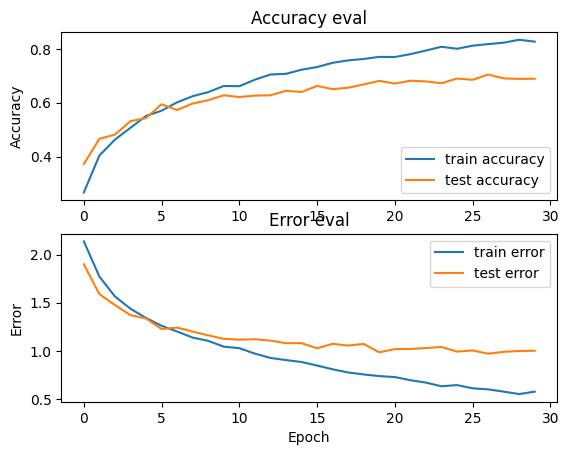

79/79 - 9s - 111ms/step - accuracy: 0.6952 - loss: 1.0044

Test accuracy: 0.6952342987060547
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step


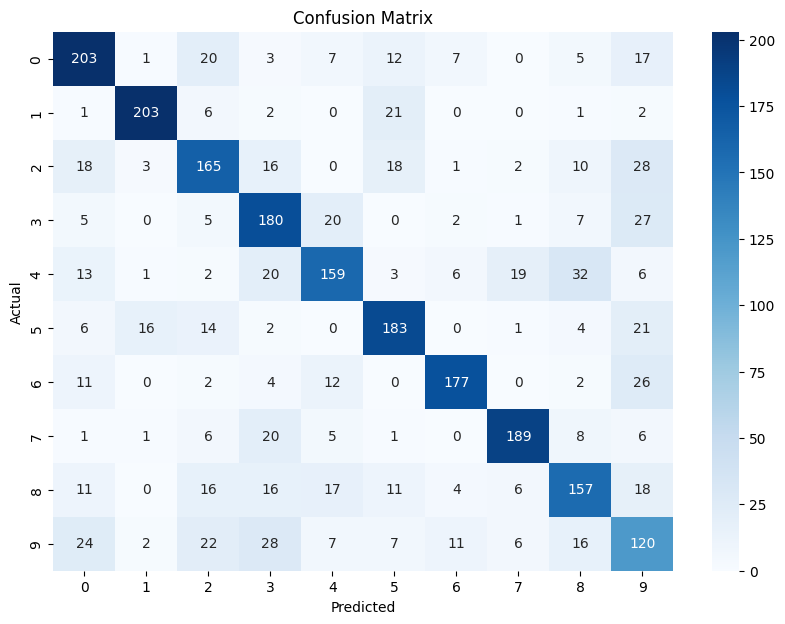

Classification Report:
              precision    recall  f1-score   support

           0     0.6928    0.7382    0.7148       275
           1     0.8943    0.8602    0.8769       236
           2     0.6395    0.6322    0.6358       261
           3     0.6186    0.7287    0.6691       247
           4     0.7004    0.6092    0.6516       261
           5     0.7148    0.7409    0.7276       247
           6     0.8510    0.7564    0.8009       234
           7     0.8438    0.7975    0.8200       237
           8     0.6488    0.6133    0.6305       256
           9     0.4428    0.4938    0.4669       243

    accuracy                         0.6952      2497
   macro avg     0.7047    0.6970    0.6994      2497
weighted avg     0.7022    0.6952    0.6973      2497

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Target: 5, Predicted label: [0]


In [ ]:
if __name__ == "__main__":

    #1. get train, validation, test splits ====> Changed! =>prepare_datasets function is changed.
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    #2. create network ====> Changed! => 1. the 3rd dimention from input_shape is removed. => Also "build_model" should change
    input_shape = (X_train.shape[1], X_train.shape[2]) # First dimention=130= number of time steps (slices) at whitch we take the MFCCs, Second dimention=13 = number of MFCCs=number of MFCCs we extract
    model = build_model(input_shape)

    #3. compile model ====> Same Setting as CNN
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model ====> Same Setting as CNN
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

    # plot accuracy/error for training and validation ====> Same Setting as CNN
    plot_history(history)

    # evaluate model on test set ====> Same Setting as CNN
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]

    # Call the evaluation function
    evaluate_model(model, X_test, y_test)

    # predict sample
    predict(model, X_to_predict, y_to_predict)

In [ ]:
# Keras H5 format
model.save("model.h5")